In [8]:
import pandas as pd
import numpy as np
import json

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


import sys
import os
sys.path.append(os.path.abspath('../'))
from tool import *

import matplotlib.pyplot as plt


data_root = '../../MyData/'

# New load data

In [2]:
train_data = torch.load("../5_synthetic_data_generation/data/train_data.pth")
train_label = torch.load("../5_synthetic_data_generation/data/train_label.pth")
test_data = torch.load("../5_synthetic_data_generation/data/test_data.pth")
test_label = torch.arange(1197)

print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

torch.Size([34683, 256])
torch.Size([34683])
torch.Size([1197, 256])
torch.Size([1197])


In [3]:
# Get cik
new_embedding_df = pd.read_csv("./data/embedding_256.csv")

unique_cik = new_embedding_df['cik'].unique()
cik_to_index = {cik: idx for idx, cik in enumerate(unique_cik)}
index_to_cik = {idx: cik for idx, cik in enumerate(unique_cik)}
print("CIK to Index Mapping:", cik_to_index)

CIK to Index Mapping: {850460: 0, 352541: 1, 1704715: 2, 1575515: 3, 1125376: 4, 1674335: 5, 1023128: 6, 1262039: 7, 1122976: 8, 1128928: 9, 58492: 10, 40533: 11, 1370946: 12, 1469367: 13, 858655: 14, 1486159: 15, 70145: 16, 77476: 17, 1593034: 18, 1140536: 19, 1353283: 20, 912728: 21, 73309: 22, 1754301: 23, 882796: 24, 1309402: 25, 1524358: 26, 80424: 27, 1551182: 28, 1283699: 29, 1158172: 30, 8947: 31, 804328: 32, 1120370: 33, 1655075: 34, 1361658: 35, 40987: 36, 1320414: 37, 1584509: 38, 1466301: 39, 1552033: 40, 1281761: 41, 93410: 42, 76282: 43, 19584: 44, 723531: 45, 1530804: 46, 101984: 47, 910329: 48, 5513: 49, 31462: 50, 1338749: 51, 1409171: 52, 821026: 53, 817720: 54, 5272: 55, 1013871: 56, 1111928: 57, 1393818: 58, 66382: 59, 812011: 60, 730708: 61, 1672013: 62, 1109242: 63, 883945: 64, 1527166: 65, 1421461: 66, 355811: 67, 1262823: 68, 26058: 69, 14930: 70, 1637459: 71, 892553: 72, 1345016: 73, 844965: 74, 1318220: 75, 819793: 76, 1175454: 77, 936468: 78, 29989: 79, 35291

In [4]:
dissimilar_df = pd.read_csv(data_root + "dissimilar_pairs_2021.csv")
print(f"length of dissimilar_df: {len(dissimilar_df)}")
print(f"dissimilar_df columns: {dissimilar_df.columns}")
company_a_cik_set = set(dissimilar_df['company_a_cik'].unique())
company_b_cik_set = set(dissimilar_df['company_b_cik'].unique())
dissimilar_union_set = company_a_cik_set.union(company_b_cik_set)
print(f"number of firms occured in dissimilar_df: {len(dissimilar_union_set)} \n")

similar_df = pd.read_csv(data_root + "pairs_gpt_competitors_2021.csv")
print(f"length of similar_df: {len(similar_df)}")
print(f"similar_df columns: {similar_df.columns}")
company_a_cik_set = set(similar_df['company_a_cik'].unique())
company_b_cik_set = set(similar_df['company_b_cik'].unique())
similar_union_set = company_a_cik_set.union(company_b_cik_set)
print(f"number of firms occured in similar_df: {len(similar_union_set)} \n")

print(f"final union set length: {len(dissimilar_union_set.union(similar_union_set))}")

# similar_df = similar_df[['company_a_cik', 'company_b_cik']]
# dissimilar_df = dissimilar_df[['company_a_cik', 'company_b_cik']]

length of dissimilar_df: 2913
dissimilar_df columns: Index(['Unnamed: 0', 'company_a_name', 'company_a_cik', 'company_a_products',
       'company_b_cik', 'company_b_name', 'company_b_tic',
       'company_b_products', 'reason_for_dissimilarity'],
      dtype='object')
number of firms occured in dissimilar_df: 1196 

length of similar_df: 2365
similar_df columns: Index(['Unnamed: 0', 'company_a_name', 'company_a_cik', 'company_b_cik',
       'company_b_name', 'company_b_tic', 'competing_products'],
      dtype='object')
number of firms occured in similar_df: 1110 

final union set length: 1197


In [5]:
exp_df = pd.read_csv("./data/embedding_256.csv")[['cik', 'tic', 'Year']]
print(len(exp_df))
exp_df.head()

1197


,cik,tic,Year
0,850460,WIRE,2021
1,352541,LNT,2021
2,1704715,AMR,2021
3,1575515,SFM,2021
4,1125376,ENSG,2021


# Create dataset

### Prepare labels

In [6]:
# Get number of unique entities
N = len(unique_cik)

# Initialize the relation matrix with -1 (unknown/no relation)
relation_matrix = -1 * np.ones((N, N))

# Fill in similar pairs
for _, row in similar_df.iterrows():
    i, j = cik_to_index[row['company_a_cik']], cik_to_index[row['company_b_cik']]
    relation_matrix[i, j] = 1
    relation_matrix[j, i] = 1  # Ensure symmetry

# Fill in dissimilar pairs
for _, row in dissimilar_df.iterrows():
    i, j = cik_to_index[row['company_a_cik']], cik_to_index[row['company_b_cik']]
    relation_matrix[i, j] = 0
    relation_matrix[j, i] = 0  # Ensure symmetry

# Set diagonal to -1 (self-relations not needed)
np.fill_diagonal(relation_matrix, -1)

# Convert to PyTorch tensor
relation_matrix = torch.tensor(relation_matrix, dtype=torch.float32)

print("Relation Matrix:\n", relation_matrix)


# Count number of 1's
num_ones = (relation_matrix == 1).sum().item()

# Count number of -1's
num_neg_ones = (relation_matrix == 0).sum().item()

print(f"Number of 1's: {num_ones}")
print(f"Number of 0's: {num_neg_ones}")

Relation Matrix:
 tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]])
Number of 1's: 4564
Number of 0's: 5826


#### **Some similar pairs are useless!**

In [6]:
# print(len(similar_df))
# print(len(dissimilar_df))
# similar_df[similar_df['company_a_cik'] == similar_df['company_b_cik']]

### Final step

In [7]:
# Define a custom dataset
class ContrastiveDataset(Dataset):
    def __init__(self, data, index_list):
        self.data = data
        self.index_list = index_list

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.index_list[idx]



train_dataset = ContrastiveDataset(train_data, train_label)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = ContrastiveDataset(test_data, torch.arange(1197))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Model training

In [ ]:
class ProjectionNet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super(ProjectionNet, self).__init__()
        
        # Define the layers sequentially
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),         # First fully connected layer
            nn.BatchNorm1d(hidden_dim),               # Batch Normalization
            nn.LeakyReLU(negative_slope=0.01),        # LeakyReLU activation
            # nn.Dropout(p=dropout_prob),               # Dropout
            nn.Linear(hidden_dim, output_dim)         # Second fully connected layer
        )
    
    def forward(self, x):
        # Pass the input through the sequential model
        return self.model(x)

# # Define contrastive loss
# class ContrastiveLoss1(nn.Module):
#     def __init__(self, margin=1.0):
#         super(ContrastiveLoss1, self).__init__()
#         self.margin = margin

#     def forward(self, z1, labels):
#         loss = 0
#         for i, j in z1:
#             distances = torch.norm(i - j, p=2, dim=0)
#             loss += (labels * distances.pow(2)) + ((1 - labels) * torch.relu(self.margin - distances).pow(2))
#         return loss.mean()

#### Train with contrastive loss 2

In [ ]:
import torch
import torch.nn.functional as F

def contrastive_loss(batch_output, pos_pairs, temperature=0.5):
    """
    Computes the contrastive loss using NT-Xent (Normalized Temperature-scaled Cross Entropy Loss).

    Args:
        batch_output (torch.Tensor): Tensor of shape (B, D) containing the model outputs.
        pos_pairs (List[Tuple[int, int]]): List of positive index pairs.
        temperature (float): Scaling factor for similarity scores.

    Returns:
        loss (torch.Tensor): Contrastive loss.
    """
    # Normalize embeddings (ensures cosine similarity)
    batch_output = F.normalize(batch_output, dim=1)

    # Compute similarity matrix
    sim_matrix = torch.mm(batch_output, batch_output.T) / temperature  # (B, B)

    # # Extract positive pair similarities
    # pos_indices = torch.tensor(pos_pairs, device=batch_output.device)
    # i_idx, j_idx = pos_indices[:, 0], pos_indices[:, 1]
    # pos_sims = sim_matrix[i_idx, j_idx]
    # exp_pos_sims = torch.exp(pos_sims)

    # Compute negative similarities
    exp_sim_matrix = torch.exp(sim_matrix)  # (B, B)

    pos_indices = torch.tensor(pos_pairs, device=batch_output.device)
    i_idx, j_idx = pos_indices[:, 0], pos_indices[:, 1]
    exp_pos_sims = exp_sim_matrix[i_idx, j_idx]

    # Create a mask to exclude positive pairs and self-similarity
    mask = torch.ones_like(sim_matrix, dtype=torch.bool, device=batch_output.device)
    mask[i_idx, j_idx] = False  # Exclude positive pairs
    mask[torch.arange(sim_matrix.size(0)), torch.arange(sim_matrix.size(0))] = False  # Exclude self-similarity

    # Compute sum of negatives
    neg_sims_sum = (exp_sim_matrix * mask).sum(dim=1)  # Sum over negatives for each sample

    # Compute NT-Xent loss
    loss = -torch.log(exp_pos_sims / (neg_sims_sum[i_idx] + exp_pos_sims))

    # Return mean loss
    return loss.mean() if loss.numel() > 0 else torch.tensor(0.0, device=batch_output.device)


In [ ]:
def contrastive_loss(batch_output, pos_pairs, temperature=0.5):
    """
    Computes the contrastive loss using NT-Xent (Normalized Temperature-scaled Cross Entropy Loss).
    
    Args:
        batch_output (torch.Tensor): Tensor of shape (B, D) containing the model outputs.
        pos_pairs (List[Tuple[int, int]]): List of positive index pairs.
        neg_pairs (List[Tuple[int, int]]): List of negative index pairs.
        temperature (float): Scaling factor for the similarity scores.

    Returns:
        loss (torch.Tensor): Contrastive loss.
    """
    # Compute similarity matrix (cosine similarity)
    batch_output = F.normalize(batch_output, dim=1)  # Normalize embeddings
    sim_matrix = torch.mm(batch_output, batch_output.T)  # (B, B) similarity matrix
    sim_matrix /= temperature

    loss = 0
    num_pairs = 0

    # Compute loss for positive pairs
    for i, j in pos_pairs:
        num_pairs += 1
        sim_ij = sim_matrix[i, j]
        exp_sim_ij = torch.exp(sim_ij)

        # Negative samples
        neg_sims = sim_matrix[i, :]
        exp_neg_sims = torch.exp(neg_sims)
        exp_neg_sims[j] = 0  # Exclude the positive pair itself

        loss += -torch.log(exp_sim_ij / (torch.sum(exp_neg_sims) + exp_sim_ij))  # NT-Xent formula

    return loss / num_pairs if num_pairs > 0 else torch.tensor(0.0, device=batch_output.device)




# def ContrastiveLoss2(batch_output, pos_pairs, neg_pairs, temperature=0.5):
#     """
#     Computes the contrastive loss using NT-Xent (Normalized Temperature-scaled Cross Entropy Loss).
    
#     Args:
#         batch_output (torch.Tensor): Tensor of shape (B, D) containing the model outputs.
#         pos_pairs (List[Tuple[int, int]]): List of positive index pairs.
#         neg_pairs (List[Tuple[int, int]]): List of negative index pairs.
#         temperature (float): Scaling factor for the similarity scores.

#     Returns:
#         loss (torch.Tensor): Contrastive loss.
#     """
#     # Normalize embeddings to ensure cosine similarity is in [-1,1]
#     batch_output = F.normalize(batch_output, dim=1)
    
#     # Compute cosine similarity matrix
#     sim_matrix = torch.mm(batch_output, batch_output.T)  # (B, B) similarity matrix
    
#     loss = 0
#     num_pairs = 0

#     # Compute loss for positive pairs
#     for i, j in pos_pairs:
#         num_pairs += 1
#         sim_ij = sim_matrix[i, j] / temperature  # Scaled similarity
#         exp_sim_ij = torch.exp(sim_ij)

#         # Negative samples: Use all negative pairs plus all non-positive pairs
#         neg_sims = torch.exp(sim_matrix[i, :] / temperature)  # All similarities for anchor i
#         neg_sims[j] = 0  # Exclude the positive pair itself

#         # Explicitly include negative pairs
#         for neg_i, neg_j in neg_pairs:
#             neg_sims[neg_j] = torch.exp(sim_matrix[neg_i, neg_j] / temperature)

#         loss += -torch.log(exp_sim_ij / (torch.sum(neg_sims) + exp_sim_ij))  # NT-Xent formula

#     return loss / num_pairs if num_pairs > 0 else torch.tensor(0.0, device=batch_output.device)


#### Make full use of the sample in each batch

In [ ]:
import itertools

def get_positive_negative_pairs(batch_indices):
    batch_size = len(batch_indices)
    
    # Extract the batch submatrix
    batch_rel_matrix = relation_matrix[batch_indices][:, batch_indices]  # Shape (B, B)

    pos_pairs = []
    neg_pairs = []

    for i, j in itertools.combinations(range(batch_size), 2):  
        rel_value = batch_rel_matrix[i, j]
        if rel_value == 1:
            pos_pairs.append((i, j))  # Store indices instead of embeddings
        elif rel_value == 0:
            neg_pairs.append((i, j))

    return pos_pairs, neg_pairs




# batch_output = [[77, 77, 77],
#                 [78, 78, 78],
#                 [80, 80, 80]]
# batch_indices = [77, 78, 80]  # These are the row/column indices of the samples in batch

# pos_pairs, neg_pairs = get_positive_negative_pairs(batch_indices, batch_output)
# print(pos_pairs)
# print(neg_pairs)

In [ ]:
input_dim = 256
output_dim = 128


model = ProjectionNet(input_dim, output_dim, 256)
criterion = ContrastiveLoss2
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    total_loss = 0
    model.train()
    for batch_data, batch_idx in train_loader:

        batch_size = batch_data.size(0)

        z1 = model(batch_data)
        pos_pairs, neg_pairs = get_positive_negative_pairs(batch_idx, z1)

        loss = torch.tensor(0.0, device=z1.device, requires_grad=True)
        if len(pos_pairs) > 0:
            loss = loss + criterion(pos_pairs, torch.ones(len(pos_pairs)))
        if len(neg_pairs) > 0:
            loss = loss + criterion(neg_pairs, torch.zeros(len(neg_pairs)))

        total_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], train_avg_Loss: {total_loss/len(train_loader):.4f}")

    total_loss = 0
    model.eval()
    with torch.no_grad():
        for batch_data, batch_idx in test_loader:

            batch_size = batch_data.size(0)

            z1 = model(batch_data)
            pos_pairs, neg_pairs = get_positive_negative_pairs(batch_idx, z1)

            loss = torch.tensor(0.0, device=z1.device, requires_grad=True)
            if len(pos_pairs) > 0:  # Check if there's at least one valid pair
                # Compute loss
                loss = loss + criterion(pos_pairs, torch.ones(len(pos_pairs)))
            if len(neg_pairs) > 0:
                loss = loss + criterion(neg_pairs, torch.zeros(len(neg_pairs)))
            
            total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], test_avg_Loss: {total_loss/len(test_loader):.4f}\n")

#### Clustering

In [43]:
model.eval()
with torch.no_grad():
    final_representation = model(test_data)
final_representation.shape

torch.Size([1197, 128])

In [44]:
exp_df['cluster_10'] = cluster(final_representation, 10)
exp_df['cluster_100'] = cluster(final_representation, 100)
exp_df

Normalized Within-Cluster Sum of Squares (WCSS): 0.014103111069503184
Normalized Within-Cluster Sum of Squares (WCSS): 0.006723239806262074


,cik,tic,Year,cluster_10,cluster_100
0,850460,WIRE,2021,3,43
1,352541,LNT,2021,2,2
2,1704715,AMR,2021,2,42
3,1575515,SFM,2021,0,35
4,1125376,ENSG,2021,9,98
...,...,...,...,...,...
1192,1021860,NOV,2021,1,47
1193,1744489,DIS,2021,8,12
1194,1102112,PACW,2021,6,16
1195,28823,DBD,2021,3,3


In [45]:
year = 2021
mode = 'forward'  # Can be 'in-sample', 'forward', or 'backtest'
returns_long = pd.read_csv(data_root+"returns_long.csv")

exp_returns = pd.merge(exp_df, returns_long, on='tic', how='inner')

exp_intra_corrs_10 = intra_industry_correlations(exp_returns, "cluster_10")
exp_avg_intra_corr_10 = np.nanmean(list(exp_intra_corrs_10.values()))
print(exp_avg_intra_corr_10)

exp_intra_corrs_100 = intra_industry_correlations(exp_returns, "cluster_100")
exp_avg_intra_corr_100 = np.nanmean(list(exp_intra_corrs_100.values()))
print(exp_avg_intra_corr_100)

print(len(exp_returns['cik'].unique()))

0.3571506610618548
0.4597556815475851
1064


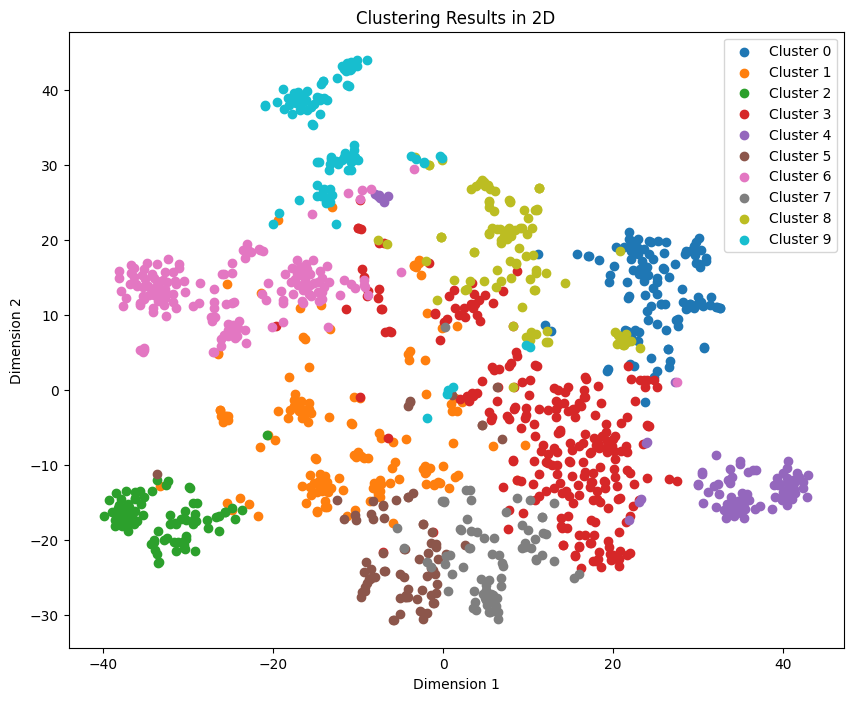

In [46]:
show_cluster_graph(final_representation, exp_df['cluster_10'])

# Pair eval

In [47]:
similar_df = pd.read_csv(data_root + "pairs_gpt_competitors_2021.csv")
similar_df = similar_df[similar_df['company_a_cik'] != similar_df['company_b_cik']]


In [48]:
similar_df_results = precision_and_false_positive(similar_df, exp_df.copy(), ['cluster_10', 'cluster_100'], 10000)
similar_df_results

Missing CIKs in pairs dataset: 0 (company A), 0 (company B)
CIKs not found in main dataset: 0 (company A), 0 (company B)
Total valid pairs: 2282
cluster_10
Original number of positive pairs: 2282
Number of positive pairs after filtering: 2282


cluster_100
Original number of positive pairs: 2282
Number of positive pairs after filtering: 2282




,Classification_Scheme,Precision,False_Positive_rate,N_Industries,Avg_Firms_per_Industry
0,cluster_10,0.779579,0.979047,10,119.70
1,cluster_100,0.595530,0.871221,100,11.97
